## Working with Time Series Data

What can we do with time series data? Track how a single measurement has changed over time, or track how multiple measurements have changed, individually or together.

The first sheet from the [2018 World Happiness Report dataset](https://worldhappiness.report/ed/2018/) is only annual data, not daily or hourly, but the measurements are pretty broad so that's ok. Tracking stock data, on the other hand, wouldn't be super useful if we just looked at year-on-year. But happiness and satisfaction, GDP, life expectancy - those things are much less volatile.

I want to track life ladder scores in a single region, seeing how countries within it have changed over the decade. After we pinpoint some of the countries with the largest changes, we can take a look at how other factors may have changed as well. Can we draw conclusions? Maybe not. But the correlations are still good to keep in mind.

### Selecting a region

To begin with, we need to decide what region to focus on. For this notebook, I'm going to take a look at th ecountries in Southeast Asia. To grab this data, I need to create a list of the countries in this region, and then use the `loc` method to return data from only these countries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [71]:
# Get rid of any FutureWarnings that might pop up

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
happy = pd.read_excel('world_happiness_original.xls', sheet_name='Table2.1')

In [9]:
# Let's take a look at the original df first

happy.head()

,country,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government,Democratic Quality,Delivery Quality,Standard deviation of ladder by country-year,Standard deviation/Mean of ladder by country-year,GINI index (World Bank estimate),"GINI index (World Bank estimate), average 2000-15","gini of household income reported in Gallup, by wp5-year"
0,Afghanistan,2008,3.723590,7.168690,0.450662,49.209663,0.718114,0.181819,0.881686,0.517637,0.258195,0.612072,-1.929690,-1.655084,1.774662,0.476600,NaN,NaN,NaN
1,Afghanistan,2009,4.401778,7.333790,0.552308,49.624432,0.678896,0.203614,0.850035,0.583926,0.237092,0.611545,-2.044093,-1.635025,1.722688,0.391362,NaN,NaN,0.441906
2,Afghanistan,2010,4.758381,7.386629,0.539075,50.008961,0.600127,0.137630,0.706766,0.618265,0.275324,0.299357,-1.991810,-1.617176,1.878622,0.394803,NaN,NaN,0.327318
3,Afghanistan,2011,3.831719,7.415019,0.521104,50.367298,0.495901,0.175329,0.731109,0.611387,0.267175,0.307386,-1.919018,-1.616221,1.785360,0.465942,NaN,NaN,0.336764
4,Afghanistan,2012,3.782938,7.517126,0.520637,50.709263,0.530935,0.247159,0.775620,0.710385,0.267919,0.435440,-1.842996,-1.404078,1.798283,0.475367,NaN,NaN,0.344540


In [12]:
# Create list of SE Asian countries
country_list = ['Cambodia', 'Philippines', 'Thailand', 'Vietnam', 'Indonesia', 'Singapore',
               'Malaysia', 'Myanmar', 'Laos']

# Create df of these countries
se_asia = happy.set_index('country').loc[country_list].reset_index()

In [13]:
se_asia['country'].value_counts()

Vietnam        12
Indonesia      12
Philippines    12
Thailand       12
Cambodia       12
Singapore      11
Malaysia       10
Laos            6
Myanmar         6
Name: country, dtype: int64

Perfect! Now we have a dataframe with only rows from the countries we're interested in.

### Cleaning the data

We have data for all the countries we're looking at, but we still need to clean the data up. What values are missing? Are we missing entire years/rows of data? What columns should we keep?

As we can see from above, most of the countries in the dataframe have 12 rows. But the data covers 13 years, so these countries may not all have information for the same years. Laos and Myanmar, however, only have 6 years of data each. Are they the most recent years?

In [6]:
# Make sure sort is set to False so that the series returned is in chronological order

se_asia['year'].value_counts(sort=False)

2006    8
2007    8
2008    8
2009    7
2010    7
2011    8
2012    8
2013    8
2014    8
2015    8
2016    7
2017    8
Name: year, dtype: int64

In [7]:
se_asia.set_index('country').loc['Laos']

,southeast_asia,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,...,east_europe,south_europe,west_europe,central_asia,east_asia,south_asia,west_asia,sub_saharan,latin_america,north_america_region
country,,,,,,,,,,,,,,,,,,,,,
Laos,1,2006,5.076226,8.052846,0.806987,53.802586,0.925082,0.447761,0.687814,0.885816,...,0,0,0,0,0,0,0,0,0,0
Laos,1,2007,5.363855,8.109043,0.789621,54.265434,0.866525,0.486279,0.580067,0.861139,...,0,0,0,0,0,0,0,0,0,0
Laos,1,2008,5.044099,8.167316,0.807086,54.710060,0.886214,0.424082,0.637409,0.829270,...,0,0,0,0,0,0,0,0,0,0
Laos,1,2011,4.703750,8.353370,0.690878,55.912094,0.881634,0.465112,0.587322,0.899812,...,0,0,0,0,0,0,0,0,0,0
Laos,1,2012,4.876085,8.417758,0.692628,56.269176,NaN,0.238068,NaN,0.916801,...,0,0,0,0,0,0,0,0,0,0
Laos,1,2017,4.623141,8.708568,0.707336,57.869576,0.891001,0.076483,0.591617,0.872792,...,0,0,0,0,0,0,0,0,0,0


In [8]:
se_asia.set_index('country').loc['Myanmar']

,southeast_asia,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,...,east_europe,south_europe,west_europe,central_asia,east_asia,south_asia,west_asia,sub_saharan,latin_america,north_america_region
country,,,,,,,,,,,,,,,,,,,,,
Myanmar,1,2012,4.438940,8.330550,0.612250,56.765915,0.691094,0.625392,0.694739,0.764304,...,0,0,0,0,0,0,0,0,0,0
Myanmar,1,2013,4.175671,8.402433,0.756725,56.990059,0.775448,0.669334,0.637766,0.803302,...,0,0,0,0,0,0,0,0,0,0
Myanmar,1,2014,4.786247,8.470104,0.774267,57.178963,NaN,0.677773,0.591633,0.857965,...,0,0,0,0,0,0,0,0,0,0
Myanmar,1,2015,4.223846,8.528501,0.752064,57.333050,0.807971,0.666991,0.633305,0.865906,...,0,0,0,0,0,0,0,0,0,0
Myanmar,1,2016,4.623120,8.576414,0.793462,57.487133,0.877491,0.658644,0.607287,0.804010,...,0,0,0,0,0,0,0,0,0,0
Myanmar,1,2017,4.154342,8.634504,0.795184,57.641220,0.886012,0.628706,0.618822,0.745647,...,0,0,0,0,0,0,0,0,0,0


In [44]:
# What about Malaysia and Singapore?

se_asia.set_index('country').loc['Singapore']['year'].unique()

array([2006, 2007, 2008, 2009, 2010, 2011, 2013, 2014, 2015, 2016, 2017])

In [45]:
se_asia.set_index('country').loc['Malaysia']['year'].unique()

array([2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015])

All of the countries are missing data for 2005, so that's not a big deal. Malaysia is missing data from its last two years, and Singapore is missing 2012 data. Myanmar and Laos are missing the most years, but Myanmar's missing data is from 2006-2011, and Laos' is from 2009-2010 and 2013-2016.

So what do we do? Because Myanmar's earliest data is 2012, we can't assume anything previous. Same with Malaysia - it wouldn't be useful for our purposes to assume that Malaysia's data for 2016 and 2017 is identical to 2015. So we only have 6 years of data for that country. 

Laos, on the other hand, has data surrounding all of the missing years/rows. Let's separate Laos from the se_asia dataframe, add some new rows (mostly with null values), and fill in all of those values with `interpolate`. We'll do this with Singapore as well.

### Add Missing Rows to Dataframe

1. Make list of columns we want in the new dataframe
2. Create new dataframe with only Laos data, with only columns from the list.
3. Add empty rows to new dataframe
4. Add country name and missing year to each new row

In [14]:
# What columns are in the dataframe?

se_asia.columns

Index(['country', 'year', 'Life Ladder', 'Log GDP per capita',
       'Social support', 'Healthy life expectancy at birth',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Positive affect', 'Negative affect',
       'Confidence in national government', 'Democratic Quality',
       'Delivery Quality', 'Standard deviation of ladder by country-year',
       'Standard deviation/Mean of ladder by country-year',
       'GINI index (World Bank estimate)',
       'GINI index (World Bank estimate), average 2000-15',
       'gini of household income reported in Gallup, by wp5-year'],
      dtype='object')

In [15]:
# Create list of columns to keep

columns_to_keep = ['country', 'year', 'Life Ladder',
       'Log GDP per capita', 'Social support',
       'Healthy life expectancy at birth', 'Freedom to make life choices',
       'Generosity', 'Perceptions of corruption', 'Positive affect',
       'Negative affect', 'Confidence in national government',
       'Democratic Quality', 'Delivery Quality']

In [17]:
# Create new dataframe with only Laos data, with only columns we want to keep, using filter

laos_df = se_asia.set_index('country').loc['Laos'].reset_index().filter(columns_to_keep)

In [19]:
laos_df

,country,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government,Democratic Quality,Delivery Quality
0,Laos,2006,5.076226,8.052846,0.806987,53.802586,0.925082,0.447761,0.687814,0.885816,0.162685,0.923247,-0.909181,-1.144349
1,Laos,2007,5.363855,8.109043,0.789621,54.265434,0.866525,0.486279,0.580067,0.861139,0.135671,0.914146,-0.947139,-1.075619
2,Laos,2008,5.044099,8.167316,0.807086,54.710060,0.886214,0.424082,0.637409,0.829270,0.201755,0.923686,-0.846235,-1.021325
3,Laos,2011,4.703750,8.353370,0.690878,55.912094,0.881634,0.465112,0.587322,0.899812,0.225278,0.981804,-0.868257,-0.997297
4,Laos,2012,4.876085,8.417758,0.692628,56.269176,NaN,0.238068,NaN,0.916801,0.386679,NaN,-0.804916,-0.882167
5,Laos,2017,4.623141,8.708568,0.707336,57.869576,0.891001,0.076483,0.591617,0.872792,0.344226,0.839935,NaN,NaN


In [20]:
# Add new rows by using loc with non-existent indices
# We'll start by making all of the new rows filled with null values

laos_df.loc[6] = np.nan
laos_df.loc[7] = np.nan
laos_df.loc[8] = np.nan
laos_df.loc[9] = np.nan
laos_df.loc[10] = np.nan
laos_df.loc[11] = np.nan

In [21]:
laos_df

,country,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government,Democratic Quality,Delivery Quality
0,Laos,2006.0,5.076226,8.052846,0.806987,53.802586,0.925082,0.447761,0.687814,0.885816,0.162685,0.923247,-0.909181,-1.144349
1,Laos,2007.0,5.363855,8.109043,0.789621,54.265434,0.866525,0.486279,0.580067,0.861139,0.135671,0.914146,-0.947139,-1.075619
2,Laos,2008.0,5.044099,8.167316,0.807086,54.710060,0.886214,0.424082,0.637409,0.829270,0.201755,0.923686,-0.846235,-1.021325
3,Laos,2011.0,4.703750,8.353370,0.690878,55.912094,0.881634,0.465112,0.587322,0.899812,0.225278,0.981804,-0.868257,-0.997297
4,Laos,2012.0,4.876085,8.417758,0.692628,56.269176,NaN,0.238068,NaN,0.916801,0.386679,NaN,-0.804916,-0.882167
5,Laos,2017.0,4.623141,8.708568,0.707336,57.869576,0.891001,0.076483,0.591617,0.872792,0.344226,0.839935,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Set all country values to Laos

laos_df['country'] = 'Laos'

In [46]:
# Create dictionary of missing years

missing_years_laos = {6: 2009,
                7: 2010,
                8: 2013,
                9: 2014,
                10: 2015,
                11: 2016}

In [47]:
# Use fillna to replace null values with years, and turn column-type back to integer

laos_df['year'] = laos_df['year'].fillna(missing_years_laos).astype(int)

In [25]:
# Make new datafeame sorted by year, descending

laos_df2 = laos_df.sort_values('year')

In [26]:
laos_df2

,country,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government,Democratic Quality,Delivery Quality
0,Laos,2006,5.076226,8.052846,0.806987,53.802586,0.925082,0.447761,0.687814,0.885816,0.162685,0.923247,-0.909181,-1.144349
1,Laos,2007,5.363855,8.109043,0.789621,54.265434,0.866525,0.486279,0.580067,0.861139,0.135671,0.914146,-0.947139,-1.075619
2,Laos,2008,5.044099,8.167316,0.807086,54.710060,0.886214,0.424082,0.637409,0.829270,0.201755,0.923686,-0.846235,-1.021325
6,Laos,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Laos,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Laos,2011,4.703750,8.353370,0.690878,55.912094,0.881634,0.465112,0.587322,0.899812,0.225278,0.981804,-0.868257,-0.997297
4,Laos,2012,4.876085,8.417758,0.692628,56.269176,NaN,0.238068,NaN,0.916801,0.386679,NaN,-0.804916,-0.882167
8,Laos,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Laos,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,Laos,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Before we continue with filling in missing values, let's set up Singapore the same way.

In [48]:
sing_df = se_asia.set_index('country').loc['Singapore'].reset_index().filter(columns_to_keep)

sing_df

,country,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government,Democratic Quality,Delivery Quality
0,Singapore,2006,6.462703,11.087921,0.904329,73.382545,0.756874,0.119886,NaN,0.750798,0.266721,0.905858,0.431533,1.934471
1,Singapore,2007,6.833755,11.133461,0.920632,73.657242,0.866892,0.274598,0.063615,0.700188,0.114407,0.933893,0.405456,2.009301
2,Singapore,2008,6.641957,11.097964,0.845259,73.976608,0.660659,0.027292,0.065775,0.720842,0.256087,0.908408,0.505373,2.039838
3,Singapore,2009,6.144677,11.061752,0.866255,74.389771,0.776382,-0.092619,0.035198,0.499599,0.207548,0.973571,0.472613,1.958158
4,Singapore,2010,6.531402,11.185884,0.864162,74.664474,0.846185,-0.036896,0.060282,0.602476,0.131343,0.904517,0.480224,1.958240
5,Singapore,2011,6.561042,11.225419,0.904474,74.849838,0.821816,-0.167730,0.098924,0.482754,0.143629,0.825415,0.544697,1.931019
6,Singapore,2013,6.533207,11.271478,0.807911,75.309906,0.827103,0.095905,0.242398,0.769633,0.147688,0.856166,0.707473,1.960737
7,Singapore,2014,7.062365,11.293592,0.822033,75.537704,0.834888,0.135153,0.132603,0.841018,0.180233,0.843873,0.543806,2.078054
8,Singapore,2015,6.619525,11.300871,0.866437,75.629265,0.886891,0.131434,0.098944,0.803124,0.141585,0.908558,0.574966,2.100870
9,Singapore,2016,6.033481,11.307663,0.925128,75.720833,0.903736,0.125498,0.047311,0.823989,0.110942,0.930617,0.622578,2.072999


In [49]:
# Add new row
sing_df.loc[11] = np.nan

# Add country to row
sing_df['country'] = 'Singapore'

# Create missing year dicitonary
missing_years_sing = {
    11: 2012
}

# Fill missing year on new row
sing_df['year'] = sing_df['year'].fillna(missing_years_sing).astype(int)

# Sort rows by year
sing_df2 = sing_df.sort_values('year')

# View new dataframe
sing_df2

,country,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government,Democratic Quality,Delivery Quality
0,Singapore,2006,6.462703,11.087921,0.904329,73.382545,0.756874,0.119886,NaN,0.750798,0.266721,0.905858,0.431533,1.934471
1,Singapore,2007,6.833755,11.133461,0.920632,73.657242,0.866892,0.274598,0.063615,0.700188,0.114407,0.933893,0.405456,2.009301
2,Singapore,2008,6.641957,11.097964,0.845259,73.976608,0.660659,0.027292,0.065775,0.720842,0.256087,0.908408,0.505373,2.039838
3,Singapore,2009,6.144677,11.061752,0.866255,74.389771,0.776382,-0.092619,0.035198,0.499599,0.207548,0.973571,0.472613,1.958158
4,Singapore,2010,6.531402,11.185884,0.864162,74.664474,0.846185,-0.036896,0.060282,0.602476,0.131343,0.904517,0.480224,1.958240
5,Singapore,2011,6.561042,11.225419,0.904474,74.849838,0.821816,-0.167730,0.098924,0.482754,0.143629,0.825415,0.544697,1.931019
11,Singapore,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Singapore,2013,6.533207,11.271478,0.807911,75.309906,0.827103,0.095905,0.242398,0.769633,0.147688,0.856166,0.707473,1.960737
7,Singapore,2014,7.062365,11.293592,0.822033,75.537704,0.834888,0.135153,0.132603,0.841018,0.180233,0.843873,0.543806,2.078054
8,Singapore,2015,6.619525,11.300871,0.866437,75.629265,0.886891,0.131434,0.098944,0.803124,0.141585,0.908558,0.574966,2.100870


Done!

### Fill in Missing Data

So, what's the best way to do this? Pandas has a few methods. The first is a parameter for the typical `fillna()` method. By specifying where want the to-fill value to come from, we can make the null value equal the value from the row above (ffill) or the row below (bfill). This is great for filling in missing data from the first and last years of the dataframe.

These two methods could actually be used for all of the missing data, but when it comes to null values that are sandwiched between two known values, we have a better method: `interpolate`, which computes the difference between two known values and fills in the nulls with this average. You can even use this for filling in multiple years! Luckily, that's not something we need this time.

In [50]:
# Fill in missing data with interpolate, bfill, and ffill

laos_df3 = laos_df2.interpolate().fillna(method='ffill').fillna(method='bfill')
sing_df3 = sing_df2.interpolate().fillna(method='ffill').fillna(method='bfill')

In [51]:
laos_df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 5
Data columns (total 14 columns):
country                              12 non-null object
year                                 12 non-null int64
Life Ladder                          12 non-null float64
Log GDP per capita                   12 non-null float64
Social support                       12 non-null float64
Healthy life expectancy at birth     12 non-null float64
Freedom to make life choices         12 non-null float64
Generosity                           12 non-null float64
Perceptions of corruption            12 non-null float64
Positive affect                      12 non-null float64
Negative affect                      12 non-null float64
Confidence in national government    12 non-null float64
Democratic Quality                   12 non-null float64
Delivery Quality                     12 non-null float64
dtypes: float64(12), int64(1), object(1)
memory usage: 1.4+ KB


In [52]:
sing_df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 10
Data columns (total 14 columns):
country                              12 non-null object
year                                 12 non-null int64
Life Ladder                          12 non-null float64
Log GDP per capita                   12 non-null float64
Social support                       12 non-null float64
Healthy life expectancy at birth     12 non-null float64
Freedom to make life choices         12 non-null float64
Generosity                           12 non-null float64
Perceptions of corruption            12 non-null float64
Positive affect                      12 non-null float64
Negative affect                      12 non-null float64
Confidence in national government    12 non-null float64
Democratic Quality                   12 non-null float64
Delivery Quality                     12 non-null float64
dtypes: float64(12), int64(1), object(1)
memory usage: 1.4+ KB


Success! We added missing years to Laos and Singapore, and filled in all of the missing values.

### Other Missing Data

Before I add these two countries back to the main dataframe, let's see if we need to fix up data for other countries.

Is there other missing data? I don't mean whole rows - we've added all that we can - but just individual null values? 

In [53]:
# Make a condition to hide all of Laos's old data

row_is_laos = se_asia['country'] == 'Laos'

In [54]:
# Any missing data besides Laos?

se_asia.mask(row_is_laos).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 19 columns):
country                                                     87 non-null object
year                                                        87 non-null float64
Life Ladder                                                 87 non-null float64
Log GDP per capita                                          87 non-null float64
Social support                                              86 non-null float64
Healthy life expectancy at birth                            87 non-null float64
Freedom to make life choices                                82 non-null float64
Generosity                                                  86 non-null float64
Perceptions of corruption                                   82 non-null float64
Positive affect                                             85 non-null float64
Negative affect                                             85 non-null float64
Confidence in nati

I'm only concerned with the columns above the Standard Deviation columns, but it does look like we're missing some data in those measurements. 

Let's just split apart the dataframe by country and approach each one individually. If they're missing data, we'll fix it. If not, we'll just hold onto that section until we concat everything together.

### Splitting the Dataframe and Filling the Data

Since we're not missing years for any of the other countries (at least, none that we can fill), we can make a single function that serves two purposes: 1) split a country off into its own dataframe, and 2) and fill in the missing values.

In [56]:
# Create new, single-country df
# Put dataframe through three cleanup methods: interpolate; fillna with foward-fill; fillna with backward-fill

def make_df_and_fill(country):
    new_df = se_asia.set_index('country').loc[country].reset_index().filter(columns_to_keep)
    new_df2 = new_df.interpolate().fillna(method='ffill').fillna(method='bfill')
    return new_df2

In [57]:
# Put remaining countries through this function

cambodia_df = make_df_and_fill('Cambodia')
indonesia_df = make_df_and_fill('Indonesia')
malaysia_df = make_df_and_fill('Malaysia')
myanmar_df = make_df_and_fill('Myanmar')
philippines_df = make_df_and_fill('Philippines')
thailand_df = make_df_and_fill('Thailand')
vietnam_df = make_df_and_fill('Vietnam')

In [65]:
# Did the function work?

print('Cambodia null:', cambodia_df.isnull().sum().sum())
print('Indonesia null:', indonesia_df.isnull().sum().sum())
print('Malaysia null:', malaysia_df.isnull().sum().sum())
print('Myanmar null:', myanmar_df.isnull().sum().sum())
print('Philippines null:', philippines_df.isnull().sum().sum())
print('Thailand null:', thailand_df.isnull().sum().sum())
print('Vietnam null:', vietnam_df.isnull().sum().sum())

Cambodia null: 0
Indonesia null: 0
Malaysia null: 0
Myanmar null: 0
Philippines null: 0
Thailand null: 0
Vietnam null: 0


The null values have been filled!

### Concatenate Dataframes

Well, all of our indiviudual-country dataframes are clean and filled. Now, so we can compare the data between them, we need to put them all together in a single dataframe.

In [66]:
# Make a list of all the dataframes we're putting together

single_country_dfs = [vietnam_df, thailand_df, sing_df3, philippines_df,
                    myanmar_df, malaysia_df, indonesia_df, cambodia_df, laos_df3]

In [67]:
# Put them together with concatenate

se_asia_best = pd.concat(single_country_dfs)

In [68]:
se_asia_best['country'].unique()

array(['Vietnam', 'Thailand', 'Singapore', 'Philippines', 'Myanmar',
       'Malaysia', 'Indonesia', 'Cambodia', 'Laos'], dtype=object)

### Mapping Results

Our dataframe is all cleaned up! Let's compare Life Ladder scores across countries, and how they've changed over time.

(2006, 2017)

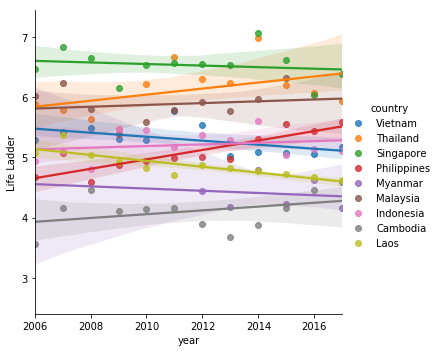

In [72]:
m = sns.lmplot(x='year', y='Life Ladder', data=se_asia_best, hue='country')
plt.xlim(2006, 2017)

Pretty! Although it's a little chaotic, we can clearly see some trend lines. Looking at how life ladder scores have changed over time, we can see that, out of all Southeast Asian countries, Philippines and Thailand have improved the most over this timeframe. On the other end, Laos has decreased in Life Ladder scores more than any other country in the region.

The lines in the chart above are the best-fit lines for each country's data, but maybe the year-on-year changes tell a different story. Let's look at how each country has changed with relplot, which allows us to view side-by-side comparisons of particular variable combinations.

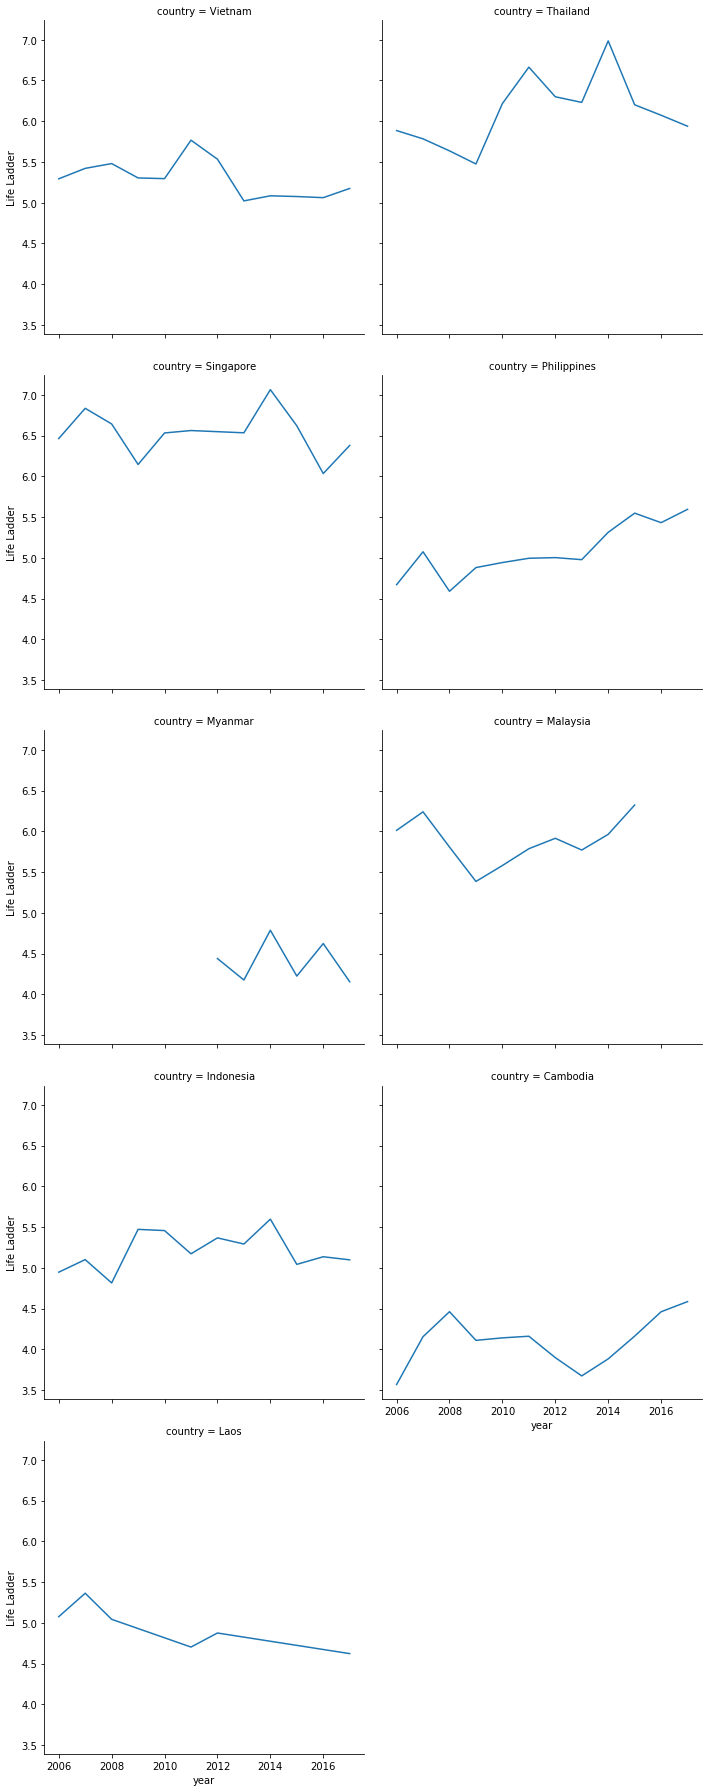

In [73]:
# Relplot is new to Seaborn 0.9.0!

sns.relplot(x='year', y='Life Ladder', data=se_asia_best, col='country', col_wrap=2, kind='line')

Charting the year-on-year Life Ladder scores in each individual country shows us just how much the bumps were smoothed over in the best-fit lines. The Philippines has been on a steady rise for almost the entire time, while Laos has been on a slow decline. Thailand had a number of high peaks within the measured timeframe, although in the past few years these scores have fallen - perhaps related to the death of their very, very popular king in 2016? It'll be interesting to see how the Life Ladder scores of both Camodia and Malaysia change in the few years, as they both appear to be on upward trends. Maybe these are just random peaks, or maybe they indicate a continuing rise in happiness.

### Correlations Between Happiness and Other Measures

I want to take a look at how other factors change alongside the Life Ladder scores. Can we infer a correlation between any of them?

Instead of looking at all of the countries, I'm going to take four: Philippines, Thailand, Laos, and Cambodia. We'll use the single-country dataframes that we created earlier, and standardize the values within them so that all measurements are on the same scale.

If we're making a function (which we should, otherwise we have to do the same thing four times), what do we need to do?

1. Assign dataframe (without country and year columns) to a new variable
2. Map the StandardScaler to the new variable
3. Create scaled features from this mapping
4. Create dataframe with scaled features, and index/columns from to_standardize dataframe
5. Concatenate country and year columns back to standardized df

In [74]:
from sklearn.preprocessing import StandardScaler

In [75]:
from sklearn_pandas import DataFrameMapper

In [76]:
def standardize_and_map_to_new_df(df):
    to_standardize = df.drop(['country', 'year'], axis=1)
    mapper = DataFrameMapper([(to_standardize.columns, StandardScaler())])
    scaled_features = mapper.fit_transform(to_standardize.copy(), 4)
    scaled_features_df = pd.DataFrame(scaled_features, index=to_standardize.index,
                                 columns=to_standardize.columns)
    standard_df = pd.concat([df['country'], df['year'], scaled_features_df], axis=1)
    return standard_df

In [77]:
# Make standardized dataframes for Thailand, Philippines, Laos, and Cambodia

standard_thai = standardize_and_map_to_new_df(thailand_df)
standard_phil = standardize_and_map_to_new_df(philippines_df)
standard_camb = standardize_and_map_to_new_df(cambodia_df)
standard_laos = standardize_and_map_to_new_df(laos_df3)

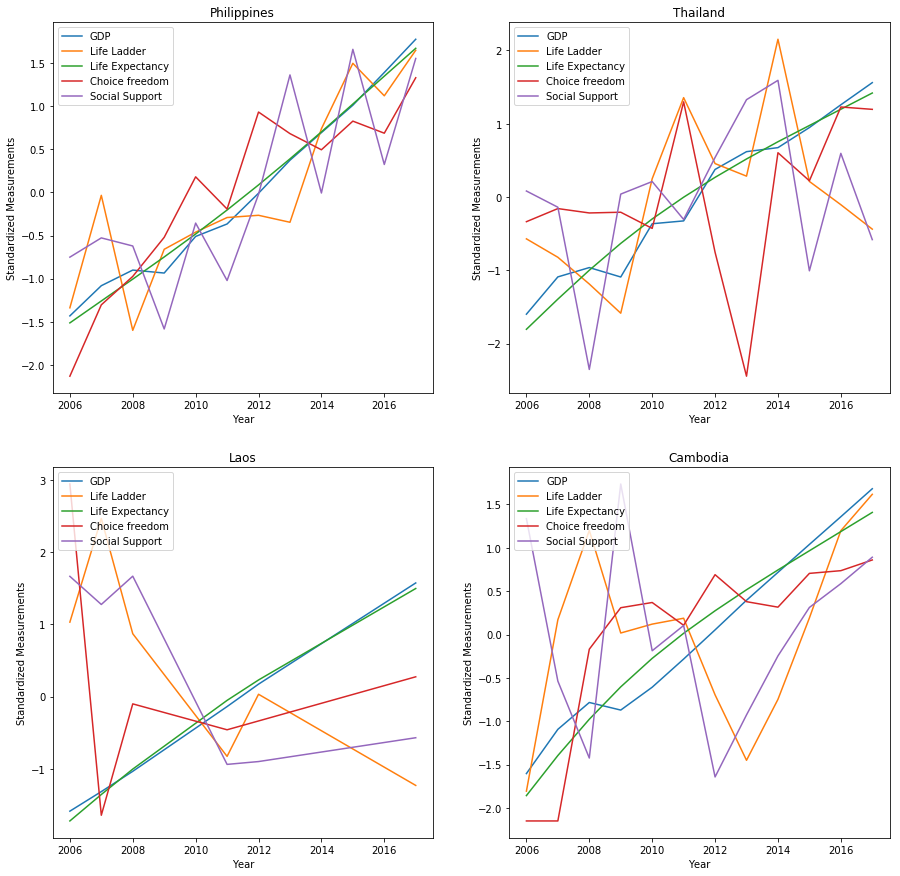

In [78]:
# Philippines
fig = plt.figure(figsize=[15, 15])
plt.tight_layout()
ax1 = fig.add_subplot(221)
ax1.plot(standard_phil['year'], standard_phil['Log GDP per capita'], label='GDP')
ax1.plot(standard_phil['year'], standard_phil['Life Ladder'], label='Life Ladder')
ax1.plot(standard_phil['year'], standard_phil['Healthy life expectancy at birth'], label='Life Expectancy')
ax1.plot(standard_phil['year'], standard_phil['Freedom to make life choices'], label='Choice freedom')
ax1.plot(standard_phil['year'], standard_phil['Social support'], label='Social Support')
ax1.set_title('Philippines')
ax1.set_xlabel('Year')
ax1.set_xticks([2006, 2008, 2010, 2012, 2014, 2016])
ax1.set_ylabel('Standardized Measurements')
ax1.legend(loc=2)

# Thailand
ax2 = fig.add_subplot(222)
ax2.plot(standard_thai['year'], standard_thai['Log GDP per capita'], label='GDP')
ax2.plot(standard_thai['year'], standard_thai['Life Ladder'], label='Life Ladder')
ax2.plot(standard_thai['year'], standard_thai['Healthy life expectancy at birth'], label='Life Expectancy')
ax2.plot(standard_thai['year'], standard_thai['Freedom to make life choices'], label='Choice freedom')
ax2.plot(standard_thai['year'], standard_thai['Social support'], label='Social Support')
ax2.set_title('Thailand')
ax2.set_xlabel('Year')
ax2.set_xticks([2006, 2008, 2010, 2012, 2014, 2016])
ax2.set_ylabel('Standardized Measurements')
ax2.legend(loc=2)

# Laos
ax3 = fig.add_subplot(223)
ax3.plot(standard_laos['year'], standard_laos['Log GDP per capita'], label='GDP')
ax3.plot(standard_laos['year'], standard_laos['Life Ladder'], label='Life Ladder')
ax3.plot(standard_laos['year'], standard_laos['Healthy life expectancy at birth'], label='Life Expectancy')
ax3.plot(standard_laos['year'], standard_laos['Freedom to make life choices'], label='Choice freedom')
ax3.plot(standard_laos['year'], standard_laos['Social support'], label='Social Support')
ax3.set_title('Laos')
ax3.set_xlabel('Year')
ax3.set_xticks([2006, 2008, 2010, 2012, 2014, 2016])
ax3.set_ylabel('Standardized Measurements')
ax3.legend(loc=2)

# Cambodia
ax4 = fig.add_subplot(224)
ax4.plot(standard_camb['year'], standard_camb['Log GDP per capita'], label='GDP')
ax4.plot(standard_camb['year'], standard_camb['Life Ladder'], label='Life Ladder')
ax4.plot(standard_camb['year'], standard_camb['Healthy life expectancy at birth'], label='Life Expectancy')
ax4.plot(standard_camb['year'], standard_camb['Freedom to make life choices'], label='Choice freedom')
ax4.plot(standard_camb['year'], standard_camb['Social support'], label='Social Support')
ax4.set_title('Cambodia')
ax4.set_xlabel('Year')
ax4.set_xticks([2006, 2008, 2010, 2012, 2014, 2016])
ax4.set_ylabel('Standardized Measurements')
ax4.legend(loc=2)



Whoa, let's try to make some sense of this!

Clearly, the two most correlated variables are a country's GDP and their healthy life expectancy. It looks like all four of these countries have improved in both measures over the past 11 years (although maybe not to the same extent - the variables are standardized *within* countries but not *between* countries, so what may look like the same amount of change on two separate charts is not).

Despite these increases, however, not every country shows increases in other measurements. Sure, everything improved in the Philippines, but look at Laos - Life Ladder and social support have decreased, while freedom to make choices has maintained a middle level after jumping significantly in the early years. Despite some drastic jumps in Thailand, most of the measures are steadily improving. And Cambodia? It looks like, after some significant decreases in the middle, everything seems to be increasing again.

## Conclusion

Well, what have we learned? With this dataset, we've used the principles of split/apply/combine to fill in null values and standardize measurements for easy comparison. We've also looked at how we can analyze measurements over time, seeing how they change, and how they change relative to other measurements.

Have we discovered anything about the World Happiness dataset? I think that this data is useful, but it has its limitations. Not every country is the same, and not all measurements move in the same way within a single country. Philippines shows a very strongly correlated rise in happiness, social support, GDP, life expectancy and choice freedom, while other countries do not show this. Is that because the Philippines are fundamentally different from its neighbors? They are, after all, the only democracy in the sample. We could posit also that GDP has something to do with these measurements - not how the GDP has changed at all, but whether the country itself is high- or low-GDP. Thailand - which is a wealthier country than Philippines - has slight upward trends, but not nearly as pronounced.

As we'll continue to find, real-world datasets are good at illustrating potential relationships, but rarely can they draw firm conclusions. The real world is messy. On the other hand, a controlled, double-blind test may be able to find strong support for hypotheses, but whether those conclusions can be applied to other data demends on other factors. 